In [1]:
#export
"""
This is for functions that sort of changes the table
structure in a dramatic way. They're the core transformations
"""
from typing import List, Union, Iterator, Callable, Any, Tuple, Dict
from collections import defaultdict, Counter, deque
from k1lib.cli.init import patchDefaultDelim, BaseCli, oneToMany, T, Table, fastF, yieldT
import k1lib.cli as cli; from k1lib.cli.typehint import *
import itertools, numpy as np, k1lib, math; import matplotlib.pyplot as plt
try: import torch; hasTorch = True
except: torch = k1lib.Object().withAutoDeclare(lambda: type("RandomClass", (object, ), {})); hasTorch = True
__all__ = ["transpose", "reshape", "insert", "splitW", "splitC",
           "joinStreams", "flatten", "joinStreamsRandom", "activeSamples",
           "table", "batched", "window", "groupBy", "ungroup",
           "insertColumn", "insertIdColumn",
           "expandE", "unsqueeze",
           "count", "hist", "permute", "accumulate", "AA_", "peek", "peekF",
           "repeat", "repeatF", "repeatFrom", "oneHot", "indexTable"]
settings = k1lib.settings.cli

In [2]:
cli.init.patchNumpy()

In [3]:
#export
class transpose(BaseCli):
    def __init__(self, dim1:int=0, dim2:int=1, fill=None):
        """Join multiple columns and loop through all rows. Aka transpose.
Example::

    # returns [[1, 4], [2, 5], [3, 6]]
    [[1, 2, 3], [4, 5, 6]] | transpose() | deref()
    # returns [[1, 4], [2, 5], [3, 6], [0, 7]]
    [[1, 2, 3], [4, 5, 6, 7]] | transpose(fill=0) | deref()

Multidimensional transpose works just like :meth:`torch.transpose` too::

    # returns (2, 7, 5, 3), but detected Tensor, so it will use builtin :meth:`torch.transpose`
    torch.randn(2, 3, 5, 7) | transpose(3, 1) | shape()
    # also returns (2, 7, 5, 3), but actually does every required computation. Can be slow if shape is huge
    torch.randn(2, 3, 5, 7) | deref(igT=False) | transpose(3, 1) | shape()

Can also work with numpy arrays::

    # returns (5, 3, 2)
    np.random.randn(2, 3, 5) | transpose(0, 2) | op().shape

Be careful with infinite streams, as transposing stream of shape (inf, 5) will
hang this operation! Either don't do it, or temporarily limit all infinite streams like
this::

    with settings.cli.context(inf=21):
        # returns (3, 21)
        [2, 1, 3] | repeat() | transpose() | shape()

Also be careful with empty streams, as you might not get any results at all::

    # returns [], as the last stream has no elements
    [[1, 2], [3, 4], []] | transpose() | deref()
    # returns [[1, 3, 0], [2, 4, 0]]
    [[1, 2], [3, 4], []] | transpose(fill=0) | deref()

:param fill: if not None, then will try to zip longest with this fill value"""
        super().__init__(); self.fill = fill
        self.d1 = min(dim1, dim2); self.d2 = max(dim1, dim2)
        self.normal = self.d1 == 0 and self.d2 == 1
    def _typehint(self, inp):
        if isinstance(inp, tArrayTypes):
            if inp.rank is None: return inp
            if inp.rank > max(self.d1, self.d2): return inp
            else: return tAny() # this case doesn't quite exist
        if self.d1 == 0 and self.d2 == 1:
            if isinstance(inp, tListIterSet):
                if isinstance(inp.child, tListIterSet):
                    return tIter(tList(inp.child.child))
        return tAny()
    def __ror__(self, it:Iterator[Iterator[T]]) -> Table[T]:
        d1 = self.d1; d2 = self.d2; fill = self.fill
        if isinstance(it, torch.Tensor): return it.transpose(d1, d2)
        if isinstance(it, np.ndarray):
            dims = list(range(len(it.shape)))
            temp = dims[d1]; dims[d1] = dims[d2]; dims[d2] = temp
            return it.transpose(dims)
        if d1 != 0 or d2 != 1: return it | cli.serial(*([transpose(fill=fill).all(i) for i in range(d1, d2)] + [transpose(fill=fill).all(i-1) for i in range(d2-1, d1, -1)]))
        if self.fill is None: return zip(*it)
        else: return itertools.zip_longest(*it, fillvalue=fill)
    @staticmethod
    def fill(fill="", dim1:int=0, dim2:int=1):
        """Convenience method to fill in missing elements of a table.
Example::

    # returns [[1, 2, 3], [4, 5, 0]]
    [[1, 2, 3], [4, 5]] | transpose.fill(0) | deref()
    # also returns [[1, 2, 3], [4, 5, 0]], demonstrating how it works underneath
    [[1, 2, 3], [4, 5]] | transpose(fill=0) | transpose(fill=0) | deref()"""
        return transpose(dim1, dim2, fill=fill) | transpose(dim1, dim2, fill=fill)
    @staticmethod
    def wrap(f, dim1:int=0, dim2:int=1, fill=None):
        """Wraps ``f`` around 2 :class:`transpose`, can be useful in combination with
:class:`k1lib.cli.init.mtmS`. Example::

    # returns [[1, 4, 3, 4], [8, 81, 10, 11]]
    [range(1, 5), range(8, 12)] | transpose.wrap(mtmS.f(apply(op()**2), 1)) | deref()
    # also returns [[1, 4, 3, 4], [8, 81, 10, 11]], demonstrating the typical way to do this
    [range(1, 5), range(8, 12)] | apply(op()**2, 1) | deref()

The example given is sort of to demonstrate this only. Most of the time, just use
:class:`~k1lib.cli.modifier.apply` with columns instead. But sometimes you need direct
access to a column, so this is how you can do it."""
        if not isinstance(f, BaseCli): f = cli.applyS(f)
        return transpose(dim1, dim2, fill) | f | transpose(dim1, dim2, fill)
#tOpt.clearPasses()
def oTranspose1(cs, ts, metadata): # `transpose() | transpose().all()` to `transpose() | apply(aS(torch.stack) | transpose())`
    tr, ap = cs; t = ts[0]
    if (not ap.normal) or (not tr.normal): return None
    if (not isinstance(ap.f, transpose)) or (not ap.f.normal): return None
    if isinstance(t, tListIterSet) and (isinstance(t.child, tTensor) or isinstance(t.child, tCollection) and isinstance(tLowest(*t.child.children), tTensor)):
        return [transpose(), cli.apply(cli.aS(torch.stack) | transpose())]
tOpt.addPass(oTranspose1, [transpose, cli.apply])

In [4]:
assert [[1, 2, 3], [4, 5, 6]] | tCheck() | transpose() | cli.deref() | yieldT == [[1, 4], [2, 5], [3, 6]]
assert [[1, 2, 3], [4, 5, 6, 7]] | tCheck() | transpose(fill=0) | cli.deref() | yieldT == [[1, 4], [2, 5], [3, 6], [0, 7]]
assert torch.randn(2, 3) | tCheck() | transpose() | cli.shape() | yieldT == (3, 2)
assert torch.randn(2, 3, 5, 7) | tCheck() | transpose(3, 1) | cli.shape() | yieldT == (2, 7, 5, 3)
assert torch.randn(2, 3, 5, 7) | tCheck() | cli.deref(igT=False) | transpose(3, 1) | cli.shape() | yieldT == (2, 7, 5, 3)
with k1lib.settings.cli.context(inf=21):
    assert [2, 1, 3] | tCheck() | cli.repeat() | transpose() | cli.shape() | yieldT == (3, 21)
assert [[1, 2], [3, 4], []] | tCheck() | transpose() | cli.deref() | yieldT == []
assert [[1, 2], [3, 4], []] | tCheck() | transpose(fill=0) | cli.deref() | yieldT == [[1, 3, 0], [2, 4, 0]]
assert [[1, 2, 3], [4, 5]] | tCheck() | transpose.fill(0) | cli.deref() | yieldT == [[1, 2, 3], [4, 5, 0]]
assert [range(1, 5), range(8, 12)] | tCheck() | transpose.wrap(cli.mtmS.f(cli.apply(lambda x: x**2), 1, 4)) | cli.deref() | yieldT == [[1, 4, 3, 4], [8, 81, 10, 11]]
assert [range(1, 5), range(8, 12)] | tCheck() | cli.apply(cli.op()**2, 1) | cli.deref() | yieldT == [[1, 4, 3, 4], [8, 81, 10, 11]]
assert np.random.randn(2, 3, 5) | tCheck() | transpose(0, 2) | cli.op().shape | yieldT == (5, 3, 2)
assert list(torch.randn(3, 4, 5)) | tOpt() | transpose() | transpose().all() | cli.deref() | cli.aS(inferType) == tList(tTensor(torch.float32))

In [5]:
#export
def _formStructure(it, dims, dimI):
    if dimI >= len(dims): return next(it)
    return [_formStructure(it, dims, dimI+1) for i in range(dims[dimI])]
class reshape(BaseCli):
    def __init__(self, *dims):
        """Reshapes the input stream into the desired shape.
Example::

    # returns [[0, 1, 2], [3, 4, 5]]
    range(6) | reshape(2, 3) | deref()
    # returns [[0, 1], [2, 3], [4, 5]]
    range(6) | reshape(3, 2) | deref()
    # returns [[0, 1], [2, 3], [4, 5]], stopped early
    range(100) | reshape(3, 2) | deref()
    # returns [[0, 1, 2], [3, 4, 5]], can leave out first dimension
    range(6) | reshape(-1, 3) | deref()
    # returns [[0, 1, 2]], won't include 2nd element, as it ran out of elements
    range(5) | reshape(-1, 3) | deref()
    # throws error, as it ran out of elements and can't fulfill the request
    range(6) | reshape(3, 3) | deref()

Unlike :meth:`torch.reshape`, the input piped into this has to be a simple iterator.
If you have a complex data structure with multiple dimensions, turn that into a simple
iterator with :class:`joinStreams` first, like this::

    # returns [[[0, 1, 2]], [[3, 4, 5]]]
    [[[0], [1]], [[2], [3]], [[4], [5]]] | joinStreams(2) | reshape(2, 1, 3) | deref()"""
        self.dims = dims
    def __ror__(self, it):
        it = iter(it)
        if self.dims[0] == -1:
            try:
                while True: yield _formStructure(it, self.dims, 1)
            except StopIteration: pass
        else:
            for i in range(self.dims[0]): yield _formStructure(it, self.dims, 1)

In [6]:
assert range(6) | tCheck() | reshape(2, 3) | cli.deref() | yieldT == [[0, 1, 2], [3, 4, 5]]
assert range(6) | tCheck() | reshape(3, 2) | cli.deref() | yieldT == [[0, 1], [2, 3], [4, 5]]
assert range(100) | tCheck() | reshape(3, 2) | cli.deref() | yieldT == [[0, 1], [2, 3], [4, 5]]
assert range(6) | tCheck() | reshape(-1, 3) | cli.deref() | yieldT == [[0, 1, 2], [3, 4, 5]]
assert range(5) | tCheck() | reshape(-1, 3) | cli.deref() | yieldT == [[0, 1, 2]]
try: range(6) | tCheck() | reshape(3, 3) | cli.deref(); assert False
except RuntimeError: pass
assert [[[0], [1]], [[2], [3]], [[4], [5]]] | tCheck() | cli.joinStreams(2) | reshape(2, 1, 3) | cli.deref() | yieldT == [[[0, 1, 2]], [[3, 4, 5]]]

In [7]:
#export
class insert(BaseCli):
    def __init__(self, element, begin=True):
        """Join element into list.
Example::

    # returns [5, 2, 6, 8]
    [2, 6, 8] | insert(5) | deref()
    # returns [2, 6, 8, 5]
    [2, 6, 8] | insert(5, begin=False) | deref()

    # returns [[3, 1], 2, 6, 8]
    [2, 6, 8] | insert([3, 1]) | deref()

:param element: the element to insert"""
        super().__init__(); self.element = element; self.begin = begin; self.expand = False
    def __ror__(self, it:Tuple[T, Iterator[T]]) -> Iterator[T]:
        element = self.element; it = iter(it)
        if self.begin: yield element; yield from it
        else: yield from it; yield element

In [8]:
assert [2, 6, 8] | tCheck() | insert(5) | cli.deref() == [5, 2, 6, 8]
assert [2, 6, 8] | tCheck() | insert(5, begin=False) | cli.deref() == [2, 6, 8, 5]
assert [2, 6, 8] | tCheck() | insert([3, 1]) | cli.deref() == [[3, 1], 2, 6, 8]

In [9]:
#export
class splitW(BaseCli):
    def __init__(self, *weights:List[float]):
        """Splits elements into multiple weighted lists. If no weights are provided,
then automatically defaults to [0.8, 0.2]. Example::

    # returns [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9]]
    range(10) | splitW(0.8, 0.2) | deref()
    # same as the above
    range(10) | splitW() | deref()

This also works with array types::

    torch.randn(100, 3) | splitW() # returns 2 tensors with shapes (80, 3) and (20, 3)

See also: :class:`splitC`"""
        super().__init__();
        if len(weights) == 0: weights = [0.8, 0.2]
        self.weights = np.array(weights)
    def __ror__(self, it):
        try: it[0]; len(it)
        except: it = list(it)
        ws = self.weights; c = 0; ws = (ws * len(it) / ws.sum()).astype(int)
        for w in ws[:-1]: yield it[c:c+w]; c += w
        yield it[c:]

In [52]:
assert range(100) | tCheck() | splitW() | cli.deref() == [range(80), range(80, 100)] | cli.deref()
assert range(10) | tCheck() | splitW() | cli.deref() == [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9]]
assert range(10) | tCheck() | splitW(0.8, 0.2) | cli.deref() == [[0, 1, 2, 3, 4, 5, 6, 7], [8, 9]]
assert torch.randn(100, 3) | tCheck() | splitW() | cli.shape().all() | cli.deref() == [[80, 3], [20, 3]]

In [11]:
#export
class splitC(BaseCli):
    def __init__(self, *checkpoints:List[float]):
        """Splits elements into multiple checkpoint-delimited lists.
Example::

    # returns [[0, 1], [2, 3, 4], [5, 6, 7, 8, 9]]
    range(10) | splitC(2, 5) | deref()
    # returns ['01', '234', '56789']
    "0123456789" | splitC(2, 5) | deref()

Here, you're specifying 2 checkpoints, 2 and 5, so it will split
the list up into 3 sections. First section is 0-2, second section
is 2-5, third section is 5-end. You can pass in fractional
checkpoints too::

    # returns [[0, 1], [2, 3, 4, 5], [6, 7, 8, 9]]
    range(10) | splitC(0.2, 0.6) | deref()

This cli might be unintuitive to remember, so if you want to just
split it up into 2 parts, check out :meth:`~k1lib.cli.filt.head.split`.

If you want to split things up by weighted length, check
out :class:`splitW`"""
        self.checkpoints = checkpoints | cli.aS(np.array)
        self.intMode = checkpoints | cli.apply(lambda x: int(x) == x) | cli.aS(all)
    def __ror__(self, it):
        try: it[0]; len(it)
        except: it = list(it)
        cs = self.checkpoints
        if not self.intMode: cs = (cs * len(it)).astype(int)
        cs = sorted(cs); yield it[:cs[0]]
        for i in range(len(cs)-1): yield it[cs[i]:cs[i+1]]
        yield it[cs[-1]:]

In [12]:
assert range(10) | splitC(2, 5) | cli.deref() == [[0, 1], [2, 3, 4], [5, 6, 7, 8, 9]]
assert range(10) | splitC(0.2, 0.6) | cli.deref() == [[0, 1], [2, 3, 4, 5], [6, 7, 8, 9]]
assert "0123456789" | splitC(2, 5) | cli.deref() == ['01', '234', '56789']

In [13]:
#export
class joinStreams(BaseCli):
    def __init__(self, dims=1):
        """Joins multiple streams.
Example::

    # returns [1, 2, 3, 4, 5]
    [[1, 2, 3], [4, 5]] | joinStreams() | deref()
    # returns [[0, 1], [2], [3, 4, 5], [6, 7, 8], [], [9, 10]]
    [[[0, 1], [2], [3, 4, 5]], [[6, 7, 8], [], [9, 10]]] | joinStreams() | deref()
    # returns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    [[[0, 1], [2], [3, 4, 5]], [[6, 7, 8], [], [9, 10]]] | joinStreams(2) | deref()

If you pass in :class:`numpy.ndarray` or :class:`torch.Tensor`, then it will
automatically use the C-accelerated version, like this::

    # returns Tensor with shape (6, 4)
    torch.randn(2, 3, 4) | joinStreams()
    # returns array with shape (6, 4)
    np.random.randn(2, 3, 4) | joinStreams()

Sometimes, you may want to impose some dimensional structure after joining all streams
together, which :class:`reshape` does.

If "joinStreams" is too unintuitive to remember, there's also an alias called
:class:`flatten`.

:param dims: how many ``joinStreams()`` do you want to do consecutively?"""
        if dims < 1: raise AttributeError(f"`dims` ({dims}) can't be less than 1, as it doesn't make any sense!")
        self.multi = cli.serial(*(joinStreams() for d in range(dims))) if dims > 1 else None
    def __ror__(self, streams:Iterator[Iterator[T]]) -> Iterator[T]:
        if self.multi != None:
            return streams | self.multi
            def gen(): yield from streams | self.multi
            return gen()
        else:
            if isinstance(streams, settings.arrayTypes): return streams.reshape(-1, *streams.shape[2:])
            else:
                def gen():
                    for stream in streams: yield from stream
                return gen()
flatten = joinStreams

In [14]:
assert [[1, 2, 3], [4, 5]] | tCheck() | joinStreams() | cli.deref() == list(range(1, 6))
assert [[[0, 1], [2], [3, 4, 5]], [[6, 7, 8], [], [9, 10]]] | tCheck() | joinStreams() | cli.deref() == [[0, 1], [2], [3, 4, 5], [6, 7, 8], [], [9, 10]]
assert [[[0, 1], [2], [3, 4, 5]], [[6, 7, 8], [], [9, 10]]] | tCheck() | joinStreams(2) | cli.deref() == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
assert torch.randn(2, 3, 4) | joinStreams() | cli.shape() == (6, 4)
assert np.random.randn(2, 3, 4) | joinStreams() | cli.shape() == (6, 4)
assert np.random.randn(2, 3, 4, 5) | joinStreams() | cli.shape() == (6, 4, 5)

In [15]:
#export
def probScale(ps, t): # t from 0 -> 1, for typical usage
    l = np.log(ps); avg = l.mean()
    a = (l-avg)*t+avg; a -= a.max()
    ans = np.exp(a); return ans/ans.sum()

[0.1058496  0.0827636  0.5632799  0.15712423 0.09098268]


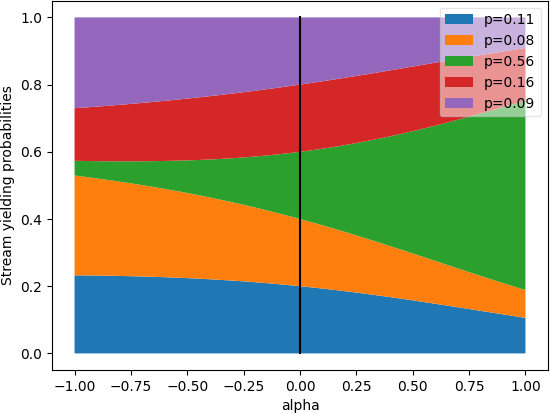

In [16]:
ps = np.exp(np.random.randn(5)); ps /= ps.sum(); x = np.linspace(-1, 1)
x | cli.apply(lambda t: probScale(ps, t) | cli.integrate(1) | cli.insert(0)) | cli.transpose() | cli.window(2) | ~cli.apply(lambda y1, y2: plt.fill_between(x, y1, y2)) | cli.ignore();
plt.legend(ps | cli.apply(lambda x: f"p={x:.2f}") | cli.deref(), framealpha=0.5); probScale(ps, 1) | cli.aS(print)
plt.plot([0, 0], [0, 1], color="black"); plt.xlabel("alpha"); plt.ylabel("Stream yielding probabilities")
im = plt.gcf() | cli.toImg(); im | cli.toBytes(imgType="PNG") | cli.file("../../docs/images/probScale.png"); im

In [17]:
#export
import random
def rand(n, ps=None):
    if ps is None:
        while True: yield random.randrange(n)
    else:
        while True: yield from np.random.choice(n, size=100, p=ps)
class joinStreamsRandom(BaseCli):
    def __init__(self, alpha=0, ps=None):
        """Join multiple streams randomly. If any streams runs out, then quits. If
any stream yields :data:`~k1lib.cli.init.yieldT`, then just ignores that result and
continue. Could be useful in active learning. Example::

    # could return [0, 1, 10, 2, 11, 12, 13, ...], with max length 20, typical length 18
    [range(0, 10), range(10, 20)] | joinStreamsRandom() | deref()
    
    stream2 = [[-5, yieldT, -4, -3], yieldT | repeat()] | joinStreams()
    # could return [-5, -4, 0, -3, 1, 2, 3, 4, 5, 6], demonstrating yieldT
    [range(7), stream2] | joinStreamsRandom() | deref()

By default, all streams are treated equally, and are yielded with equal probabilities.
However, you can tweak these probabilities a little bit, to your liking. This is
controlled by the parameter ``alpha``:

.. image:: ../images/probScale.png

If ``alpha`` is 0, then all probabilities will be the same. If ``alpha`` is 1,
then all probabilities are proportional to the length of the input stream. The
original intention was to vary ``alpha`` just from 0 to 1, but it can actually
be of any number::

    [range(0, 10), range(10, 100)] | joinStreamsRandom(0) | shape(0) # returns around 21, because it favors both streams equally
    [range(0, 10), range(10, 100)] | joinStreamsRandom(1) | shape(0) # returns around 90, because it favors the second array 9x more
    [range(0, 10), range(10, 100)] | joinStreamsRandom(100) | shape(0) # returns 90, because it highly favors the second array
    [range(0, 10), range(10, 100)] | joinStreamsRandom(-100) | shape(0) # returns 10, because it highly favors the first array

:param alpha: if not zero, does a weighted joining, instead of totally uniform probability
:param ps: if specified, use these probabilities, else try to determine from the lengths of the input streams"""
        super().__init__(); self.alpha = alpha; self.ps = ps
    def __ror__(self, streams:Iterator[Iterator[T]]) -> Iterator[T]:
        alpha = self.alpha; ps = self.ps; streams = list(streams); nStreams = len(streams)
        if alpha != 0:
            if ps is None:
                try: ps = np.array([len(st) for st in streams])
                except:
                    streams = [list(st) for st in streams]
                    ps = np.array([len(st) for st in streams])
            else: ps = np.array(list(ps))*1.0
        else: ps = np.array([1/nStreams]*nStreams)
        ps = probScale(ps/ps.sum(), alpha)
        streams = [iter(st) for st in streams]
        try:
            for streamIdx in rand(len(streams), ps):
                o = next(streams[streamIdx])
                if not o is yieldT: yield o # "not is" to fix numpy `==`
        except StopIteration: pass

In [18]:
assert len([range(0, 10), range(10, 20)] | joinStreamsRandom() | cli.deref()) <= 20
assert [range(5), yieldT | cli.repeat()] | joinStreamsRandom() | cli.deref() == [0, 1, 2, 3, 4]
stream2 = [[-5, yieldT, -4, -3], yieldT | cli.repeat()] | joinStreams()
a = len([range(100), stream2] | joinStreamsRandom() | cli.deref())
assert a == 103, f"{a}"
assert [range(0, 10), range(10, 100)] | joinStreamsRandom(100) | cli.shape(0) == 90
assert [range(0, 10), range(10, 100)] | joinStreamsRandom(-100) | cli.shape(0) == 10
assert 20 < (cli.repeatF(lambda: [range(0, 10), range(10, 100)] | joinStreamsRandom(0) | cli.shape(0), 10000) | cli.toMean()) < 22
assert 89 < (cli.repeatF(lambda: [range(0, 10), range(10, 100)] | joinStreamsRandom(1) | cli.shape(0), 10000) | cli.toMean()) < 91

In [19]:
#export
class activeSamples(BaseCli):
    def __init__(self, limit:int=100, p:float=0.95):
        """Yields active learning samples.
Example::

    o = activeSamples()
    ds = range(10) # normal dataset
    ds = [o, ds] | joinStreamsRandom() # dataset with active learning capability
    next(ds) # returns 0
    next(ds) # returns 1
    next(ds) # returns 2
    o.append(20)
    next(ds) # can return     3     or 20
    next(ds) # can return (4 or 20) or 4

So the point of this is to be a generator of samples. You can define your dataset
as a mix of active learning samples and standard samples. Whenever there's a data
point that you want to focus on, you can add it to ``o`` and it will eventially yield
it.

.. warning::

    It might not be a good idea to set param ``limit`` to higher numbers than
    100. This is because, the network might still not understand a wrong sample
    after being shown multiple times, and will keep adding that wrong sample
    back in, distracting it from other samples, and reduce network's accuracy
    after removing active learning from it.
    
    If ``limit`` is low enough (from my testing, 30-100 should be fine), then
    old wrong samples will be kicked out, allowing for a fresh stream of wrong
    samples coming in, and preventing the problem above. If you found that
    removing active learning makes the accuracy drops dramatically, then try
    decreasing the limit.

:param limit: max number of active samples. Discards samples if number of samples
    is over this.
:param p: probability of actually adding the samples in"""
        super().__init__(); self.p = p
        self.samples = deque([], limit)
    def append(self, item):
        """Adds 1 sample."""
        if random.random() < self.p: self.samples.append(item)
    def extend(self, items):
        """Adds multiple samples."""
        for item in items: self.append(item)
    def __iter__(self):
        samples = self.samples
        while True:
            if len(samples) == 0: yield yieldT
            else: yield samples.popleft()

In [20]:
#export
def table(delim:str=None):
    """Basically ``op().split(delim).all()``. This exists because this is used
quite a lot in bioinformatics. Example::

    # returns [['a', 'bd'], ['1', '2', '3']]
    ["a|bd", "1|2|3"] | table("|") | deref()"""
    return cli.op().split(patchDefaultDelim(delim)).all()

In [21]:
assert ["a|bd", "1|2|3"] | tCheck() | table("|") | cli.deref() == [['a', 'bd'], ['1', '2', '3']]

In [22]:
#export
def _batch(it, bs, includeLast):
    l = []; it = iter(it)
    try:
        while True:
            for i in range(bs): l.append(next(it))
            yield l; l = []
    except StopIteration:
        if includeLast and len(l) > 0: yield l
def _batchRange(it, bs, includeLast):
    start, stop, step = it.start, it.stop, it.step
    lastCur = start; cur = lastCur + bs*step
    while cur <= stop:
        yield range(lastCur, cur, step)
        lastCur = cur; cur += bs*step
    if includeLast and lastCur < stop:
        yield range(lastCur, stop, step)
def _batchSliceable(it, bs, includeLast):
    cur = 0; n = len(it)
    while (cur+1)*bs <= n:
        yield it[cur*bs:(cur+1)*bs]
        cur += 1
    if includeLast:
        ans = it[cur*bs:(cur+1)*bs]
        if len(ans) > 0: yield ans
class batched(BaseCli):
    def __init__(self, bs=32, includeLast=False):
        """Batches the input stream.
Example::

    # returns [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    range(11) | batched(3) | deref()
    # returns [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]
    range(11) | batched(3, True) | deref()
    # returns [[0, 1, 2, 3, 4]]
    range(5) | batched(float("inf"), True) | deref()
    # returns []
    range(5) | batched(float("inf"), False) | deref()
    
Can work well and fast with :class:`torch.Tensor` and :class:`numpy.ndarray`::

    # both returns torch.Tensor of shape (2, 3, 4, 5)
    torch.randn(6, 4, 5) | batched(3)
    torch.randn(7, 4, 5) | batched(3)

Also, if input is a :class:`range`, then to save time, a bunch of other
ranges will be returned, instead of a bunch of lists, for performance::

    # returns [range(0, 3), range(3, 6), range(6, 9)]
    range(11) | batched(3) | toList()
"""
        super().__init__(); self.bs = bs; self.includeLast = includeLast
    def __ror__(self, it):
        bs = self.bs; includeLast = self.includeLast
        if bs == float("inf"):
            if includeLast: return [it]
            return []
        if not includeLast and isinstance(it, k1lib.settings.cli.arrayTypes):
            n = it.shape[0] // bs; it = it[:n*bs]
            return it.reshape(n, bs, *it.shape[1:])
        if isinstance(it, range): return _batchRange(it, bs, includeLast)
        try: it[0]; len(it); return _batchSliceable(it, bs, includeLast)
        except: return _batch(it, bs, includeLast)

In [23]:
assert range(9) | tCheck() | batched(3) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
assert range(11) | tCheck() | batched(3) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
assert range(11) | tCheck() | batched(3) | cli.toList() == [range(0, 3), range(3, 6), range(6, 9)]
assert range(11) | tCheck() | batched(3, True) | cli.toList() == [range(0, 3), range(3, 6), range(6, 9), range(9, 11)]
assert range(11) | tCheck() | batched(3, True) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]
assert list(range(9)) | tCheck() | batched(3) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
assert list(range(11)) | tCheck() | batched(3) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
assert list(range(11)) | tCheck() | batched(3, True) | cli.deref() == [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]
assert range(5) | tCheck() | batched(float("inf"), True) | cli.deref() == [[0, 1, 2, 3, 4]]
assert range(5) | tCheck() | batched(float("inf"), False) | cli.deref() == []
assert torch.randn(6, 4, 5) | tCheck() | batched(3) | cli.op().shape | cli.op() == torch.Size([2, 3, 4, 5])
assert torch.randn(7, 4, 5) | tCheck() | batched(3) | cli.op().shape | cli.op() == torch.Size([2, 3, 4, 5])
assert torch.randn(9, 4, 5) | tCheck() | batched(3) | cli.op().shape | cli.op() == torch.Size([3, 3, 4, 5])
assert np.random.randn(7, 4, 5) | tCheck() | batched(3) | cli.op().shape | cli.op() == (2, 3, 4, 5)

In [24]:
#export
nothing = object()
class window(BaseCli):
    def __init__(self, n, newList=False, pad=nothing):
        """Slides window of size n forward and yields the windows.
Example::

    # returns [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
    range(5) | window(3) | deref()
    # returns [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, None], [4, None, None]]
    range(5) | window(3, pad=None) | deref()

If you are doing strange transformations to the result, like
transposing it, then it might complain that the internal deque
(double-ended queue) mutated during iteration. In that case,
then set ``newList`` to True. It's not True by default because
multiple lists will be created, all of which needs memory
allocation, which will be slower::

    # takes 15ms
    range(100000) | window(100) | ignore()
    # takes 48ms, because of allocating lists
    range(100000) | window(100) | ignore()

:param n: size of the window
:param newList: whether to create a new list out of every window or
    not. If False (default), less robust but faster. If True, more
    robust but slower
:param pad: whether to pad the output stream on the end, so that it
    has the same number of elements as the input stream or not"""
        self.n = n; self.listF = (lambda x: list(x)) if newList else (lambda x: iter(x))
        self.pad = pad; self.padBool = pad is not nothing # why do this? Cause in applyMp, "nothing" takes on multiple identities
    def __ror__(self, it):
        n = self.n; pad = self.pad; q = deque([], n); listF = self.listF
        for e in it:
            q.append(e)
            if len(q) == n: yield listF(q); q.popleft()
        if self.padBool:
            for i in range(n-1):
                q.append(pad)
                yield listF(q); q.popleft()

In [25]:
assert range(5) | tCheck() | window(3) | cli.deref() == [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
assert range(5) | tCheck() | window(3, True) | cli.deref() == [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
assert range(5) | tCheck() | window(3, pad=None) | cli.deref() == [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, None], [4, None, None]]

In [26]:
#export
class groupBy(BaseCli):
    def __init__(self, column:int, separate:bool=False, removeCol:bool=None):
        """Groups table by some column.
Example::

    a = [[2.3, 5],
         [3.4, 2],
         [4.5, 2],
         [5.6, 5],
         [6.7, 1]]
    a | groupBy(1) | deref()

This returns::

    [[[6.7, 1]],
     [[3.4, 2], [4.5, 2]],
     [[2.3, 5], [5.6, 5]]]

Should have O(n log(n)) time complexity. What if ``separate`` is True::

    a | groupBy(1, True) | deref()

This returns::

    [[1, [[6.7]]],
     [2, [[3.4], [4.5]]],
     [5, [[2.3], [5.6]]]]

What if ``removeCol`` is False::

    a | groupBy(1, True, False) | deref()

This returns::

    [[1, [[6.7, 1]]],
     [2, [[3.4, 2], [4.5, 2]]],
     [5, [[2.3, 5], [5.6, 5]]]]

There's another perspective and way to think about this operation. A lot of
libraries (like pandas) expect the uncompressed, "flat" version (the variable
``a`` in the examples above). But throughout my time using cli, the grouped
version (separate=True) is usually much more useful and amenable to
transformations. It also occupies less memory too, as the columns with duplicated
elements are deleted.

So, you can sort of think :class:`groupBy` is converting pandas dataframes
into a more easily digestible form. But because the prevalence of those libraries,
after doing all the transformations you want, sometimes it's necessary to flatten
it again, which :class:`ungroup` does.

If you want to group text lines by some pattern im them, :class:`~k1lib.cli.grep.grep`
might be better for you.

:param column: which column to group by
:param separate: whether to separate out the column to sort of form a dict or not. See example
:param removeCol: whether to remove the grouped-by column. Defaults to True if
    ``separate=True``, and False if ``separate=False``"""
        self.column = column; self.separate = separate
        if removeCol is None: removeCol = separate # if separate, then remove cols, else don't do it
        self.removeCol = removeCol
    def __ror__(self, it):
        it = it | cli.deref(2); c = self.column; separate = self.separate; removeCol = self.removeCol
        it = it | cli.sort(c, False); sentinel = object()
        it = iter(it); a = [next(it, sentinel)]
        if a[0] is sentinel: return
        v = a[0][c]
        try:
            while True:
                e = next(it)
                if e[c] == v: a.append(e)
                else:
                    if removeCol: a = a | ~cli.cut(c)
                    if separate: yield [v, a]
                    else: yield a
                    a = [e]; v = a[0][c]
        except StopIteration:
            if len(a) > 0:
                if removeCol: a = a | ~cli.cut(c)
                if separate: yield [v, a]
                else: yield a

In [27]:
a = [[2.3, 5], [3.4, 2], [4.5, 2], [5.6, 5], [6.7, 1]]
assert a | tCheck() | groupBy(1) | cli.deref() == [[[6.7, 1]], [[3.4, 2], [4.5, 2]], [[2.3, 5], [5.6, 5]]]
assert a | tCheck() | cli.apply(torch.tensor, 1) | groupBy(1) | cli.apply(cli.op().item(), 1).all() | cli.deref() == [[[6.7, 1]], [[3.4, 2], [4.5, 2]], [[2.3, 5], [5.6, 5]]]
assert a | tCheck() | groupBy(1, True) | cli.deref() == [[1, [[6.7]]], [2, [[3.4], [4.5]]], [5, [[2.3], [5.6]]]]
assert a | tCheck() | groupBy(1, True, False) | cli.deref() == [[1, [[6.7, 1]]], [2, [[3.4, 2], [4.5, 2]]], [5, [[2.3, 5], [5.6, 5]]]]

In [48]:
#export
class ungroup(BaseCli):
    def __init__(self, single=False, begin=False, insertCol:bool=True):
        """Ungroups things that were grouped using a specific mode of
:class:`groupBy`. Particularly useful to transform some complex data
structure into a flat dataframe so that you can plug into pandas. Example::

    a = [[2.3, 5], [3.4, 2], [4.5, 2], [5.6, 5], [6.7, 1]]
    # returns [[6.7, 1], [3.4, 2], [4.5, 2], [2.3, 5], [5.6, 5]]
    a | groupBy(1, True) | ungroup() | deref()
    # returns [[6.7], [3.4], [4.5], [2.3], [5.6]]
    a | groupBy(1, True) | ungroup(False) | deref()

Just as a reminder, this is the output of :class:`groupBy` after executing ``a | groupBy(1, True)``::

    [[1, [[6.7]]],
     [2, [[3.4], [4.5]]],
     [5, [[2.3], [5.6]]]]

A lot of times, your data is a little bit different, like this perhaps::

    [[1, [6.7]],
     [2, [3.4, 4.5]],
     [5, [2.3, 5.6]]]

A way to fix this would be to add ``apply(wrapList().all(), 1)`` before :class:`ungroup`.
But because this is so common, I've added in the parameter ``single`` for that. Just set
it to True::

    # returns [[6.7, 1], [3.4, 2], [4.5, 2], [2.3, 5], [5.6, 5]]
    [[1, [6.7]],
     [2, [3.4, 4.5]],
     [5, [2.3, 5.6]]] | ungroup(single=True)

:param single: whether the table in each group has a single column or not
:param begin: whether to insert the column at the beginning or at the end.
    Only works if ``insertCol`` is True
:param insertCol: whether to insert the column into the table or not"""
        self.insertCol = insertCol; self.single = single; self.begin = begin
    def __ror__(self, it):
        preprocess = cli.apply(cli.wrapList().all(), 1) if self.single else cli.iden(); begin = self.begin
        if self.insertCol: return it | preprocess | ~cli.apply(lambda x, arr: arr | cli.insert(x, begin).all()) | cli.joinStreams()
        else: return it | preprocess | cli.cut(1) | cli.joinStreams()

In [49]:
assert a | groupBy(1, True) | ungroup() | cli.deref() == [[6.7, 1], [3.4, 2], [4.5, 2], [2.3, 5], [5.6, 5]]
assert a | groupBy(1, True) | ungroup(False) | cli.deref() == [[6.7], [3.4], [4.5], [2.3], [5.6]]
assert [[1, [6.7]],
 [2, [3.4, 4.5]],
 [5, [2.3, 5.6]]] | ungroup(single=True) | cli.deref() == [[6.7, 1], [3.4, 2], [4.5, 2], [2.3, 5], [5.6, 5]]

In [30]:
#export
class insertColumn(BaseCli):
    def __init__(self, column:List[T], begin=True, fill=""):
        """Inserts a column at beginning or end.
Example::

    # returns [['a', 1, 2], ['b', 3, 4]]
    [[1, 2], [3, 4]] | insertColumn(["a", "b"]) | deref()
    # returns [[1, 2, 'a'], [3, 4, 'b']]
    [[1, 2], [3, 4]] | insertColumn(["a", "b"], begin=False) | deref()"""
        self.column = column; self.begin = begin; self.fill = fill
    def __ror__(self, it):
        return it | transpose(fill=self.fill) | insert(self.column, begin=self.begin) | transpose(fill=self.fill)

In [31]:
assert [[1, 2], [3, 4]] | tCheck() | insertColumn(["a", "b"]) | cli.deref() == [['a', 1, 2], ['b', 3, 4]]
assert [[1, 2], [3, 4]] | tCheck() | insertColumn(["a", "b"], begin=False) | cli.deref() == [[1, 2, 'a'], [3, 4, 'b']]

In [32]:
#export
def insertIdColumn(table=False, begin=True):
    """Inserts an id column at the beginning (or end).
Example::

    # returns [[0, 'a', 2], [1, 'b', 4]]
    [["a", 2], ["b", 4]] | insertIdColumn(True) | deref()
    # returns [[0, 'a'], [1, 'b']]
    "ab" | insertIdColumn()

:param table: if False, then insert column to an Iterator[str], else treat
    input as a full fledged table"""
    def a(it):
        if table:
            if begin: return ([i, *e] for i, e in enumerate(it))
            else: return ([*e, i] for i, e in enumerate(it))
        else:
            if begin: return ([i, e] for i, e in enumerate(it))
            else: return ([e, i] for i, e in enumerate(it))
    return cli.aS(a)

In [33]:
assert [["a", 2], ["b", 4]] | tCheck() | insertIdColumn(True) | cli.deref() == [[0, 'a', 2], [1, 'b', 4]]
assert "ab" | tCheck() | insertIdColumn() | cli.deref() == [[0, 'a'], [1, 'b']]

Table operations tests:

In [34]:
assert ["a,b", "d,e"] | tCheck() | cli.op().split(",").all() | cli.deref() == [['a', 'b'], ['d', 'e']]
assert ["a|bd", "1|2|3"] | tCheck() | cli.op().split("|").all() | cli.deref() == [['a', 'bd'], ['1', '2', '3']]
assert [[1, 2], [3, 4], [5, 6]] | tCheck() | cli.join("|").all() | cli.deref() == ['1|2', '3|4', '5|6']

In [35]:
#export
class expandE(BaseCli):
    def __init__(self, f:Callable[[T], List[T]], column:int):
        """Expands table element to multiple columns.
Example::

    # returns [['abc', 3, -2], ['de', 2, -5]]
    [["abc", -2], ["de", -5]] | expandE(lambda e: (e, len(e)), 0) | deref()

:param f: Function that transforms 1 row element to multiple elements"""
        super().__init__(fs=[f]); self.f = f; self.column = column
    def __ror__(self, it):
        f = self.f; c = self.column
        def gen(row):
            for i, e in enumerate(row):
                if i == c: yield from f(e)
                else: yield e
        return (gen(row) for row in it)

In [36]:
assert [["abc", -2], ["de", -5]] | tCheck() | expandE(lambda e: (e, len(e)), 0) | cli.deref() == [['abc', 3, -2], ['de', 2, -5]]

In [37]:
#export
def unsqueeze(dim:int=0):
    """Unsqueeze input iterator.
Example::

    t = [[1, 2], [3, 4], [5, 6]]
    # returns (3, 2)
    t | shape()
    # returns (1, 3, 2)
    t | unsqueeze(0) | shape()
    # returns (3, 1, 2)
    t | unsqueeze(1) | shape()
    # returns (3, 2, 1)
    t | unsqueeze(2) | shape()

Behind the scenes, it's really just ``wrapList().all(dim)``, but the "unsqueeze" name
is a lot more familiar. Also note that the inverse operation "squeeze" is sort of
``item().all(dim)``, if you're sure that this is desirable::

    t = [[1, 2], [3, 4], [5, 6]]
    # returns (3, 2)
    t | unsqueeze(1) | item().all(1) | shape()"""
    return cli.wrapList().all(dim)
def oUnsqueeze(cs, ts, metadata): # reminder: if change this then also change the example in llvm.rst
    a = cs[0]; t = ts[0]; i = 0;
    if not isinstance(t, tArrayTypes): return None
    while isinstance(a, cli.apply) and a.normal: i += 1; a = a.f
    if not isinstance(a, cli.wrapList): return None
    t = t.__class__(t.child, t.rank+1 if t.rank is not None else None)
    if isinstance(t, tNpArray): return [cli.aS(lambda x: np.expand_dims(x, i)).hint(t)]
    else: return [cli.aS(lambda x: x.unsqueeze(i)).hint(t)]
tOpt.addPass(oUnsqueeze, [cli.apply], 4)

In [38]:
t = [[1, 2], [3, 4], [5, 6]]
assert t | tCheck() | cli.shape() == (3, 2)
assert t | tCheck() | unsqueeze(0) | cli.shape() == (1, 3, 2)
assert t | tCheck() | unsqueeze(1) | cli.shape() == (3, 1, 2)
assert t | tCheck() | unsqueeze(2) | cli.shape() == (3, 2, 1)
t = torch.randn(3, 2)
assert t | tOpt() | unsqueeze(0) | cli.shape() == (1, 3, 2)
assert t | tOpt() | unsqueeze(1) | cli.shape() == (3, 1, 2)
assert t | tOpt() | unsqueeze(2) | cli.shape() == (3, 2, 1)
assert t | tOpt() | unsqueeze(2) | cli.aS(type) == torch.Tensor

In [39]:
#export
class count(BaseCli):
    def __init__(self):
        """Finds unique elements and returns a table with [frequency, value, percent]
columns. Example::

    # returns [[1, 'a', '33%'], [2, 'b', '67%']]
    ['a', 'b', 'b'] | count() | deref()"""
        super().__init__()
    def _typehint(self, inp):
        i = tAny()
        if isinstance(inp, tListIterSet): i = inp.child
        return tIter(tCollection(int, i, str))
    def __ror__(self, it:Iterator[str]):
        it = it | cli.apply(lambda row: (tuple(row) if isinstance(row, list) else row))
        c = Counter(it); s = sum(c.values())
        return [[v, k, f"{round(100*v/s)}%"] for k, v in c.items()] # has to scan through the entire thing anyway, which is long enough already, so just turn it into a list
    @staticmethod
    def join():
        """Joins multiple counts together.
Example::

    # returns [[2, 'a', '33%'], [4, 'b', '67%']]
    ['a', 'b', 'b'] | repeat(2) | applyMp(count() | deref()) | count.join() | deref()

This is useful when you want to get the count of a really long list/iterator using multiple cores"""
        def inner(counts):
            values = defaultdict(lambda: 0)
            for _count in counts:
                if _count is None: continue
                for v, k, *_ in _count:
                    values[k] += v
            s = values.values() | cli.toSum()
            return [[v, k, f"{round(100*v/s)}%"] for k, v in values.items()]
        return cli.applyS(inner)

In [40]:
assert ['a', 'b', 'b'] | tCheck() | count() | cli.deref() == [[1, 'a', '33%'], [2, 'b', '67%']]
assert ['a', 'b', 'b'] | tCheck() | cli.repeat(2) | cli.applyMp(count() | cli.deref()) | count.join() | cli.deref() == [[2, 'a', '33%'], [4, 'b', '67%']]

In [53]:
#export
class hist(BaseCli):
    def __init__(self, bins:int=30):
        """Bins a long 1d array. Effectively creating a historgram, without
actually plotting it. Example::

    np.random.randn(1000) | hist(5)

That returns something like::

    (array([-2.31449761, -1.17406889, -0.03364017,  1.10678854,  2.24721726]),
     array([ 41, 207, 432, 265,  55]),
     1.1404287156493986)

This format goes with :meth:`~matplotlib.pyplot.bar` directly like this::

    np.random.randn(1000) | hist(10) | ~aS(plt.bar)

If you have tons of data that's handled in multiple processes, but you want to
get an overall histogram, you can do something like this::

    # bad solution, runs slow, accurate
    fileNames | applyMp(cat() | toFloat() | aS(list)) | joinStreams() | hist() | ~aS(plt.bar)
    # good solution, runs fast, slightly inaccurate
    fileNames | applyMp(cat() | toFloat() | hist(300)) | hist.join() | ~aS(plt.bar)

Let's say in each process, you have 10M records, and that you have 1000 processes in total.
In the first solution, you transfer all records (10B records total) to a single process,
then calculate the histogram of them. The transfer overhead is going to be absolutely
enourmous, as well as the computation. This really defeats the purpose of doing
multiprocessing.

In the second solution, you "convert" 10M records into 600 numbers for each process,
which scales up to 600k numbers for all processes. Although big, but certainly
manageable with current hardware. So the data transfer cost is not a lot at all. The
histogram merging part also executes relatively fast, as it only creates an internal
array of 3M length. See over :meth:`hist.join` for param details

:params bins: how many bins should the histogram has?"""
        self.bins = bins
    def __ror__(self, it):
        if not isinstance(it, settings.arrayTypes): it = list(it)
        y, x = np.histogram(it, bins=self.bins)
        delta = x[1] - x[0]; x = (x[1:] + x[:-1])/2
        return x, y, delta
    @staticmethod
    def join(scale:float=1e4, bins:int=None, log:bool=True, xlog:bool=False):
        """Joins multiple histograms together.
Example::

    a = np.random.randn(1000); b = np.random.randn(1000)+3
    [a, b] | joinStreams() | hist() | head(2) | ~aS(plt.plot) # ---------------------------------- Ground truth
    [a, b] | hist(300).all() | hist.join(scale=1e4) | head(2) | ~aS(plt.plot) # ------------------ Log joining
    [a, b] | hist(300).all() | hist.join(scale=1e4, log=False) | head(2) | ~aS(plt.plot, ".") # -- Linear joining
    plt.legend(["Ground truth", "Log", "Linear"]); plt.grid(True); plt.ylabel("Frequency"); plt.xlabel("Value");

This results in this:

.. image:: ../images/hist1.png

As you can see, this process is only approximate, but is accurate enough in everyday
use. If you are a normal user, then this is probably enough. However, if you're a
mathematician and really care about the accuracy of this, read on.

.. admonition:: Performance vs accuracy

    As mentioned in :class:`hist`, joining histograms from across processes can really speed
    things up big time. But the joining process is complicated, with multiple parameters
    and different tradeoffs for each config. In this example, scale = 1e4, bins = 30,
    OG bins = 300, log = True. "OG bins" is the number of bins coming into :meth:`hist.join`

    To get the best accuracy possible, you should set scale and OG bins high. If better
    performance is desired, you should first lower scale, then lower OG bins, then finally lower
    bins.

.. admonition:: Log scale

    Take a look at this piece of code::
    
        a, b = np.random.randn(1000)*1, np.random.randn(3000000)*0.3+3
        [a, b] | joinStreams() | hist() | head(2) | ~aS(plt.plot)
        [a, b] | hist(300).all() | hist.join(scale=1e4) | head(2) | ~aS(plt.plot)
        [a, b] | hist(300).all() | hist.join(scale=1e4, log=False) | head(2) | ~aS(plt.plot, ".")
        plt.yscale("log"); plt.legend(["Ground truth", "Log", "Linear"]); plt.grid(True); plt.ylabel("Frequency"); plt.xlabel("Value");

    This results in:

    .. image:: ../images/hist2.png

    This shows how log mode is generally better than linear mode when the frequencies span
    across multiple orders of magnitude. So why not delete linear mode directly? Well, I have
    not formally proved that log scale case fully covers the linear case, although in practice
    it seems so. So just to be cautious, let's leave it in

.. admonition:: Scale

    The setup is just like in the "Log scale" section, but with scale = 1e3 instead of the default 1e4:

    .. image:: ../images/hist3.png
    
    Remember that the higher the scale, the more accurate, but also the longer it runs. If
    the difference in high and low frequencies are bigger than scale, then the low
    frequency values are dropped.

:param scale: how big a range of frequencies do we want to capture?
:param bins: output bins. If not specified automatically defaults to 1/10 the
    original number of bins
:param log: whether to transform everything to log scale internally on the y axis
:param xlog: whether to transform everything to log scale internally on the x axis"""
        def inner(it):
            it = it | (cli.apply(cli.apply(math.log), 0) if xlog else cli.iden()) | cli.deref()
            _bins = bins if bins is not None else it | cli.cut(0) | cli.shape(0).all() | cli.toMean() | cli.op()/10 | cli.aS(int)
            maxY = max(it | cli.cut(1) | cli.toMax().all() | cli.toMax() | cli.op()/scale, 1e-9)
            if log: it = it | cli.apply(lambda x: np.log(x+1e-9)-math.log(maxY) | cli.aS(np.exp) | cli.aS(np.round) | cli.op().astype(int), 1) | cli.deref()
            else: it = it | cli.apply(lambda y: (y/maxY).astype(int), 1) | cli.deref()
            x, y, delta = it | cli.cut(0, 1) | cli.transpose().all() | cli.joinStreams() | ~cli.apply(lambda a,b: [a]*b) | cli.joinStreams() | cli.aS(list) | cli.aS(np.array) | hist(_bins)
            return x | ((cli.apply(math.exp) | cli.deref()) if xlog else cli.iden()), y*maxY, delta
        return cli.aS(inner)

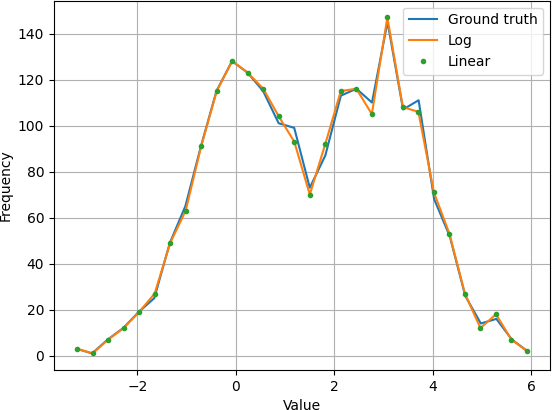

In [52]:
a = np.random.randn(1000); b = np.random.randn(1000)+3
[a, b] | joinStreams() | hist() | cli.head(2) | ~cli.aS(plt.plot) # ---------------------------------- Ground truth
[a, b] | hist(300).all() | hist.join(scale=1e4) | cli.head(2) | ~cli.aS(plt.plot) # ------------------ Log joining
[a, b] | hist(300).all() | hist.join(scale=1e4, log=False) | cli.head(2) | ~cli.aS(plt.plot, ".") # -- Linear joining
plt.legend(["Ground truth", "Log", "Linear"]); plt.grid(True); plt.ylabel("Frequency"); plt.xlabel("Value");
im = plt.gcf() | cli.toImg(); im | cli.toBytes(imgType="PNG") | cli.file("../../docs/images/hist1.png"); im

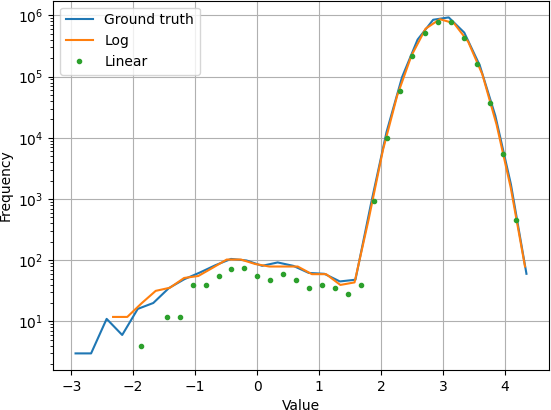

In [57]:
a, b = np.random.randn(1000)*1, np.random.randn(3000000)*0.3+3
[a, b] | joinStreams() | hist() | cli.head(2) | ~cli.aS(plt.plot)
[a, b] | hist(300).all() | hist.join(scale=1e4) | cli.head(2) | ~cli.aS(plt.plot)
[a, b] | hist(300).all() | hist.join(scale=1e4, log=False) | cli.head(2) | ~cli.aS(plt.plot, ".")
plt.yscale("log"); plt.legend(["Ground truth", "Log", "Linear"]); plt.grid(True); plt.ylabel("Frequency"); plt.xlabel("Value");
im = plt.gcf() | cli.toImg(); im | cli.toBytes(imgType="PNG") | cli.file("../../docs/images/hist2.png"); im

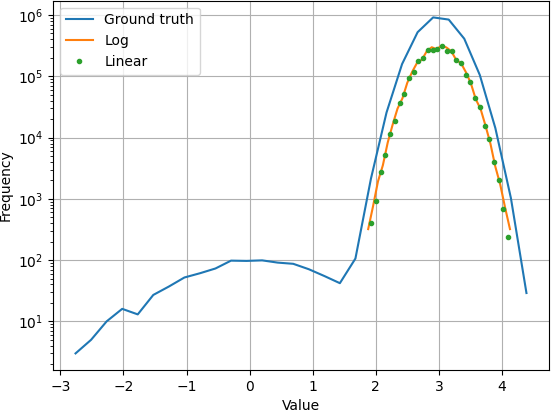

In [59]:
a, b = np.random.randn(1000)*1, np.random.randn(3000000)*0.3+3
[a, b] | joinStreams() | hist() | cli.head(2) | ~cli.aS(plt.plot)
[a, b] | hist(300).all() | hist.join(scale=1e3) | cli.head(2) | ~cli.aS(plt.plot)
[a, b] | hist(300).all() | hist.join(scale=1e3, log=False) | cli.head(2) | ~cli.aS(plt.plot, ".")
plt.yscale("log"); plt.legend(["Ground truth", "Log", "Linear"]); plt.grid(True); plt.ylabel("Frequency"); plt.xlabel("Value");
im = plt.gcf() | cli.toImg(); im | cli.toBytes(imgType="PNG") | cli.file("../../docs/images/hist3.png"); im

In [37]:
#export
def _permuteGen(row, pers):
    row = list(row); return (row[i] for i in pers)
class permute(BaseCli):
    def __init__(self, *permutations:List[int]):
        """Permutes the columns. Acts kinda like :meth:`torch.Tensor.permute`.
Example::

    # returns [['b', 'a'], ['d', 'c']]
    ["ab", "cd"] | permute(1, 0) | deref()"""
        super().__init__(); self.permutations = permutations
    def __ror__(self, it:Iterator[str]):
        p = self.permutations
        for row in it: yield _permuteGen(row, p)

In [38]:
assert ["ab", "cd"] | tCheck() | permute(1, 0) | cli.deref() == [['b', 'a'], ['d', 'c']]
assert ["ab", "cd"] | tCheck() | permute(1, 0) | transpose() | cli.deref() == [['b', 'd'], ['a', 'c']]

In [39]:
#export
class accumulate(BaseCli):
    def __init__(self, columnIdx:int=0, avg=False):
        """Groups lines that have the same row[columnIdx], and
add together all other columns, assuming they're numbers. Example::

    # returns [['a', 10.5, 9.5, 14.5], ['b', 1.1, 2.2, 3.3]]
    [["a", 1.1, 2.2, 3.4],
     ["a", 1.1, 2.2, 7.8],
     ["a", 8.3, 5.1, 3.3],
     ["b", 1.1, 2.2, 3.3]] | accumulate(0) | deref()

:param columnIdx: common column index to accumulate
:param avg: calculate average values instead of sum"""
        super().__init__(); self.columnIdx = columnIdx; self.avg = avg
        self.dict = defaultdict(lambda: defaultdict(lambda: 0))
        self.keyAppearances = defaultdict(lambda: 0)
    def __ror__(self, it:Iterator[str]):
        for row in it:
            row = list(row); key = row[self.columnIdx]
            row.pop(self.columnIdx); self.keyAppearances[key] += 1
            for i, e in enumerate(row):
                try: self.dict[key][i] += float(e)
                except: self.dict[key][i] = e
        for key, cols in self.dict.items():
            ncol = len(cols)
            if self.avg:
                for i, col in enumerate(cols):
                    if isinstance(col, (int, float)): cols[i] /= self.keyAppearances[key]
            elems = list(cols.values()); elems.insert(self.columnIdx, key); yield elems

In [40]:
assert [["a", 1.1, 2.2, 3.4],
["a", 1.1, 2.2, 7.8],
["a", 8.3, 5.1, 3.3],
["b", 1.1, 2.2, 3.3]] | tCheck() | accumulate(0) | cli.deref() == [['a', 10.5, 9.5, 14.5], ['b', 1.1, 2.2, 3.3]]

In [41]:
#export
class AA_(BaseCli):
    def __init__(self, *idxs:List[int], wraps=False):
        """Returns 2 streams, one that has the selected element, and the other
the rest. Example::

    # returns [5, [1, 6, 3, 7]]
    [1, 5, 6, 3, 7] | AA_(1)
    # returns [[5, [1, 6, 3, 7]]]
    [1, 5, 6, 3, 7] | AA_(1, wraps=True)

You can also put multiple indexes through::

    # returns [[1, [5, 6]], [6, [1, 5]]]
    [1, 5, 6] | AA_(0, 2)

If you don't specify anything, then all indexes will be sliced::

    # returns [[1, [5, 6]], [5, [1, 6]], [6, [1, 5]]]
    [1, 5, 6] | AA_()

As for why the strange name, think of this operation as "AĀ". In statistics,
say you have a set "A", then "not A" is commonly written as A with an overline
"Ā". So "AA\_" represents "AĀ", and that it first returns the selection A.

:param wraps: if True, then the first example will return [[5, [1, 6, 3, 7]]]
    instead, so that A has the same signature as Ā"""
        super().__init__(); self.idxs = idxs; self.wraps = wraps
    def __ror__(self, it:List[Any]) -> List[List[List[Any]]]:
        super().__ror__(it); idxs = self.idxs; it = list(it)
        if len(idxs) == 0: idxs = range(len(it))
        def gen(idx):
            return [it[idx], [v for i, v in enumerate(it) if i != idx]]
        if not self.wraps and len(idxs) == 1: return gen(idxs[0])
        return [gen(idx) for idx in idxs]

In [42]:
assert [1, 5, 6, 3, 7] | tCheck() | AA_(1) == [5, [1, 6, 3, 7]]
assert [1, 5, 6, 3, 7] | tCheck() | AA_(1, wraps=True) == [[5, [1, 6, 3, 7]]]
assert [1, 5, 6] | tCheck() | AA_(0, 2) == [[1, [5, 6]], [6, [1, 5]]]
assert [1, 5, 6] | tCheck() | AA_() == [[1, [5, 6]], [5, [1, 6]], [6, [1, 5]]]

In [43]:
#export
class peek(BaseCli):
    def __init__(self):
        """Returns (firstRow, iterator). This sort of peaks at the first row,
to potentially gain some insights about the internal formats. The returned
iterator is not tampered. Example::

    e, it = iter([[1, 2, 3], [1, 2]]) | peek()
    print(e) # prints "[1, 2, 3]"
    s = 0
    for e in it: s += len(e)
    print(s) # prints "5", or length of 2 lists

You kinda have to be careful about handling the ``firstRow``, because you might
inadvertently alter the iterator::

    e, it = iter([iter(range(3)), range(4), range(2)]) | peek()
    e = list(e) # e is [0, 1, 2]
    list(next(it)) # supposed to be the same as `e`, but is [] instead

The example happens because you have already consumed all elements of the first
row, and thus there aren't any left when you try to call ``next(it)``."""
        super().__init__()
    def __ror__(self, it:Iterator[T]) -> Tuple[T, Iterator[T]]:
        it = iter(it); sentinel = object(); row = next(it, sentinel)
        if row == sentinel: return None, []
        def gen(): yield row; yield from it
        return row, gen()

In [44]:
e, it = iter([iter(range(3)), range(4), range(2)]) | peek()
e = list(e); assert e == [0, 1, 2]
assert list(next(it)) == []
e, it = iter([[1, 2, 3], [1, 2]]) | peek(); assert e == [1, 2, 3]; s = 0
for e in it: s += len(e)
assert s == 5

In [45]:
#export
class peekF(BaseCli):
    def __init__(self, f:Union[BaseCli, Callable[[T], T]]):
        r"""Similar to :class:`peek`, but will execute ``f(row)`` and
return the input Iterator, which is not tampered. Example::

    it = lambda: iter([[1, 2, 3], [1, 2]])
    # prints "[1, 2, 3]" and returns [[1, 2, 3], [1, 2]]
    it() | peekF(lambda x: print(x)) | deref()
    # prints "1\n2\n3"
    it() | peekF(headOut()) | deref()"""
        super().__init__(fs=[f]); self.f = f
    def __ror__(self, it:Iterator[T]) -> Iterator[T]:
        it = iter(it); sentinel = object(); row = next(it, sentinel)
        if row == sentinel: return []
        def gen(): yield row; yield from it
        self.f(row); return gen()

In [46]:
it = lambda: iter([[1, 2, 3], [1, 2]])
with k1lib.captureStdout() as out:
    assert it() | peekF(lambda x: print(x)) | cli.deref() == [[1, 2, 3], [1, 2]]
assert out() == ["[1, 2, 3]", '']
with k1lib.captureStdout() as out:
    assert it() | peekF(cli.headOut()) | cli.deref() == [[1, 2, 3], [1, 2]]
assert out() == ["1", "2", "3", '']

In [47]:
#export
class repeat(BaseCli):
    def __init__(self, limit:int=None):
        """Yields a specified amount of the passed in object. If you intend
to pass in an iterator, then make a list out of it first, as second copy of
iterator probably won't work as you will have used it the first time. Example::

    # returns [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
    [1, 2, 3] | repeat(3) | toList()

:param repeat: if None, then repeats indefinitely"""
        super().__init__(); self.limit = limit
    def _typehint(self, inp): return tIter(inp)
    def __ror__(self, o:T) -> Iterator[T]:
        limit = self.limit if self.limit != None else k1lib.settings.cli.inf
        for i in itertools.count():
            if i >= limit: break
            yield o

In [48]:
assert [1, 2, 3] | tCheck() | repeat(10) | cli.head(3) | cli.deref() == [[1, 2, 3], [1, 2, 3], [1, 2, 3]]

In [49]:
#export
def repeatF(f, limit:int=None, **kwargs):
    """Yields a specified amount generated by a specified function.
Example::

    # returns [4, 4, 4]
    repeatF(lambda: 4, 3) | toList()
    # returns 10
    repeatF(lambda: 4) | head() | shape(0)

    f = lambda a: a+2
    # returns [8, 8, 8]
    repeatF(f, 3, a=6) | toList()

:param limit: if None, then repeats indefinitely
:param kwargs: extra keyword arguments that you can pass into the function

See also: :class:`repeatFrom`"""
    f = fastF(f); limit = limit if limit != None else k1lib.settings.cli.inf
    if len(kwargs) == 0:
        for i in itertools.count():
            if i >= limit: break
            yield f()
    else:
        for i in itertools.count():
            if i >= limit: break
            yield f(**kwargs)

In [50]:
assert repeatF(lambda: 4, 3) | tCheck() | cli.toList() == [4, 4, 4]
assert repeatF(lambda: 4) | tCheck() | cli.head() | cli.shape(0) == 10
with k1lib.settings.cli.context(inf=21):
    assert repeatF(lambda: 4) | tCheck() | cli.shape() == (21,)
f = lambda a: a+2
assert repeatF(f, 3, a=6) | tCheck() | cli.toList() == [8, 8, 8]

In [88]:
#export
class repeatFrom(BaseCli):
    def __init__(self, limit:int=None):
        """Yields from a list. If runs out of elements, then do it again for
``limit`` times. Example::

    # returns [1, 2, 3, 1, 2]
    [1, 2, 3] | repeatFrom() | head(5) | deref()
    # returns [1, 2, 3, 1, 2, 3]
    [1, 2, 3] | repeatFrom(2) | deref()

.. note::

    For advanced users who wants to modify the resulting stream mid-way, read this section

    Because this reuses elements inside the input iterator, it's necessary
    that the input feels like a list and not an iterator. So in order to make
    this work::

        # returns [1, 2, 3, 1, 2, 3]
        iter([1, 2, 3]) | repeatFrom(2) | deref()

    It's necessary to turn the input iterator into a list. However, sometimes you
    may want to update the input iterator values, so as to make things extra
    dynamic, like this::

        l = [1, 2, 3]
        def g(): yield from l; yield from l
        def h():
            for i, e in enumerate(g()):
                if i == 3: l.append(5) # modifies the list mid-way
                yield e

        h() | deref() # returns [1, 2, 3, 1, 2, 3, 5]

    But if you do this, it wouldn't work::

        l = [1, 2, 3]
        def h():
            for i, e in enumerate(iter(l) | repeatFrom(2)):
                if i == 3: l.append(5)
                yield e
        h() | deref() # returns [1, 2, 3, 1, 2, 3]

    This is because internally, :class:`repeatFrom` turns the iterator into a
    list, and continues yielding from that list, and thus won't use the updated
    values. To do it, you have to make the input feels like a list (can get length)::

        l = [1, 2, 3]
        def h():
            for i, e in enumerate(l | repeatFrom(2)):
                if i == 3: l.append(5)
                yield e
        h() | deref() # returns [1, 2, 3, 1, 2, 3, 5]

:param limit: if None, then repeats indefinitely"""
        super().__init__(); self.limit = limit
    def _typehint(self, inp):
        i = tAny()
        if isinstance(inp, tListIterSet): i = inp.child
        if isinstance(inp, tArrayTypes): i = inp
        return tIter(i)
    def __ror__(self, it:Iterator[T]) -> Iterator[T]:
        try: len(it)
        except: it = list(it)
        limit = self.limit or k1lib.settings.cli.inf
        for i in itertools.count():
            if i >= limit: break
            yield from it

In [89]:
assert [1, 2, 3] | tCheck() | repeatFrom(10) | cli.head(5) | cli.deref() == [1, 2, 3, 1, 2]
assert [1, 2, 3] | tCheck() | repeatFrom(2) | cli.deref() == [1, 2, 3, 1, 2, 3]
range(5) | tOpt() | repeatFrom() | cli.head(12) | cli.deref() | yieldT # make sure it does not loop infinitely
assert iter([1, 2, 3]) | tCheck() | repeatFrom(2) | cli.deref() == [1, 2, 3, 1, 2, 3]
l = [1, 2, 3]
def g(): yield from l; yield from l
def h():
    for i, e in enumerate(g()):
        if i == 3: l.append(5) # modifies the list mid-way
        yield e
assert h() | cli.deref() == [1, 2, 3, 1, 2, 3, 5]; l = [1, 2, 3]
def h():
    for i, e in enumerate(iter(l) | repeatFrom(2)):
        if i == 3: l.append(5)
        yield e
assert h() | cli.deref() == [1, 2, 3, 1, 2, 3]; l = [1, 2, 3]
def h():
    for i, e in enumerate(l | repeatFrom(2)):
        if i == 3: l.append(5)
        yield e
assert h() | cli.deref() == [1, 2, 3, 1, 2, 3, 5]

In [53]:
#export
def oneHotRow(i, n): ans = [0]*n; ans[i] = 1; return ans
class oneHot(BaseCli):
    _groups = {}
    def __init__(self, col, n:int=0, group:str=None, sep:bool=False):
        """One-hot encode some column in a table.
Example::

    a = [
     [1, 2, "A"],
     [3, 4, "B"],
     [5, 6, "C"]]
    b = [
     [7, 8, "A"],
     [9, 10, "B"],
     [11, 12, "B"]]
    [*a, *b] | oneHot(2) | deref()
    [*a, *b] | oneHot(2, 3, "abcd") | deref()

Last 2 statements both return this::

    [[1, 2, 1, 0, 0],
     [3, 4, 0, 1, 0],
     [5, 6, 0, 0, 1],
     [7, 8, 1, 0, 0],
     [9, 10, 0, 1, 0],
     [11, 12, 0, 1, 0]]

You can also separate the encoded column out like this::

    [*a, *b] | oneHot(2, sep=True) | deref()

Which returns this::

    [[1, 2, [1, 0, 0]],
     [3, 4, [0, 1, 0]],
     [5, 6, [0, 0, 1]],
     [7, 8, [1, 0, 0]],
     [9, 10, [0, 1, 0]],
     [11, 12, [0, 1, 0]]]

The natural way to do this is to use with without ``n`` and ``group`` parameters.
But sometimes, your one hot encoding is spreaded across multiple datasets in
multiple dataloaders, and so the order and length of the encoding might not be
the same, which will mess up your training process.

That's why, you can specify ``group``, which will share encoding information
across all :class:`oneHot` clis that have the same group name. If you choose to
do this then you have to also specify what's the size of the encoding, because
the cli can't really infer the size when it potentially has not seen all the data
right?

:param col: which column one hot encode and expand into
:param n: (optional) total number of different elements
:param group: (optional) group name
:param sep: (optional) whether to separate the variable out into its own list"""
        self.col = col; self.n = n; self.group = group; self.sep = sep
        if (n != 0 and group is not None) and (n == 0 or group is None):
            raise Exception("You have to specify both `n` and `group` at the same time if you want to use them")
        if group is not None:
            if group not in oneHot._groups:
                oneHot._groups[group] = dict()
            self.d = oneHot._groups[group]
        else: self.d = dict()
    def _typehint(self, inp):
         # TODO
        if isinstance(inp, tListIterSet):
            if isinstance(inp.child, tListIterSet):
                pass
            elif isinstance(inp.child, tListIterSet):
                pass
            pass
        return tIter(tAny())
    def __ror__(self, it):
        c = self.col; d = self.d; n = self.n; sep = self.sep
        if n == 0:
            it = it | cli.deref(2); n = it | cli.cut(c) | cli.aS(set) | cli.shape(0)
        for row in it:
            e = row[c]
            try: e[0]; len(e)
            except: e = list(e)
            if e not in d: d[e] = oneHotRow(len(d), n)
            if sep: yield [*row[:c], d[e], *row[c+1:]]
            else:   yield [*row[:c], *d[e], *row[c+1:]]
        return
        _d = it | cli.cut(c) | cli.aS(set) | cli.sort(None, False) | cli.deref(); n = len(_d)
        _d = _d | insertIdColumn(begin=False) | cli.apply(cli.aS(oneHotRow, n), 1) | transpose() | cli.toDict()
        for row in it: yield [*row[:c], *_d[row[c]], *row[c+1:]]

In [54]:
a = [[1, 2, "A"], [3, 4, "B"], [5, 6, "C"]]
b = [[7, 8, "A"], [9, 10, "B"], [11, 12, "B"]]
assert [*a, *b] | oneHot(2) | cli.deref() == [[1, 2, 1, 0, 0], [3, 4, 0, 1, 0], [5, 6, 0, 0, 1], [7, 8, 1, 0, 0], [9, 10, 0, 1, 0], [11, 12, 0, 1, 0]]
assert [*a, *b] | oneHot(2, 3, "abcd") | cli.deref() == [[1, 2, 1, 0, 0], [3, 4, 0, 1, 0], [5, 6, 0, 0, 1], [7, 8, 1, 0, 0], [9, 10, 0, 1, 0], [11, 12, 0, 1, 0]]
assert [*a, *b] | oneHot(2, sep=True) | cli.deref() == [[1, 2, [1, 0, 0]], [3, 4, [0, 1, 0]], [5, 6, [0, 0, 1]], [7, 8, [1, 0, 0]], [9, 10, [0, 1, 0]], [11, 12, [0, 1, 0]]]

In [55]:
#export
class indexTable(BaseCli):
    def __init__(self, *cols):
        """Indexes a table by some columns.
Example::

    a = [
        [0, 3, 0.1],
        [0, 4, 0.2],
        [1, 3, 0.3],
        [1, 4, 0.4],
    ]
    # returns {3: [[0, 3, 0.1], [1, 3, 0.3]], 4: [[0, 4, 0.2], [1, 4, 0.4]]}
    a | indexTable(1)
    # returns {0: [[0, 3, 0.1], [0, 4, 0.2]], 1: [[1, 3, 0.3], [1, 4, 0.4]]}
    a | indexTable(0)
    # returns {3: {0: [[0, 3, 0.1]], 1: [[1, 3, 0.3]]},    4: {0: [[0, 4, 0.2]], 1: [[1, 4, 0.4]]}}
    a | indexTable(1, 0)"""
        self.cols = cols
    def __ror__(self, it):
        if len(self.cols) == 0: return it
        col = self.cols[0]
        return it | groupBy(col) | cli.apply(lambda group: [group[0][col], group | indexTable(*self.cols[1:])]) | cli.toDict()

In [56]:
a = [[0, 3, 0.1], [0, 4, 0.2], [1, 3, 0.3], [1, 4, 0.4]]
assert a | indexTable(1) == {3: [[0, 3, 0.1], [1, 3, 0.3]], 4: [[0, 4, 0.2], [1, 4, 0.4]]}
assert a | indexTable(0) == {0: [[0, 3, 0.1], [0, 4, 0.2]], 1: [[1, 3, 0.3], [1, 4, 0.4]]}
assert a | indexTable(1, 0) == {3: {0: [[0, 3, 0.1]], 1: [[1, 3, 0.3]]},    4: {0: [[0, 4, 0.2]], 1: [[1, 4, 0.4]]}}

In [3]:
!../../export.py cli/structural

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/cli/../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.3.7.6
Uninstalling k1lib-1.3.7.6:
  Successfully uninstalled k1lib-1.3.7.6
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top